### Import libraries and functions

In [9]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import ClassifierChain

from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import LabelPowerset

#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss

from collections import Counter
from nltk.tokenize import WordPunctTokenizer
wpt = WordPunctTokenizer()

### Load training and testing data, and combine into one dataframe

In [2]:
# Load downloaded training dataset to dataframe
df_train = pd.read_csv('train.csv')

# Load downloaded testing dataset to dataframes
df_test_work = pd.read_csv('test.csv')
df_testlabel_work = pd.read_csv('test_labels.csv')

# Remove downloaded testing data that were not labeled
df_test = df_test_work.drop(df_testlabel_work[df_testlabel_work['toxic'] ==-1].index.values)
df_testlabel = df_testlabel_work[df_testlabel_work['toxic'] !=-1]

# Combined downloaded testing comments and testing labels
df_test_full = df_test.merge(df_testlabel)

# Combined downloaded training and testing data into one full data set
df = df_train.append(df_test_full)

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Clean comment text and split data into training and test sets

In [27]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [6]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

In [7]:
train, test = train_test_split(df, random_state=424, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(149777,)
(73772,)


### PART 3

### Classifier Chain + LinearSVC w/ CountVectorizer

In [10]:
cc_pipeline = Pipeline([
                    ('vect', CountVectorizer(min_df=10, ngram_range=(1, 1),stop_words='english')),
                    ('clf', ClassifierChain(LinearSVC()))])

cc_pipeline.fit(X_train, train[categories].values)

prediction_cc = cc_pipeline.predict(X_test) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

In [12]:
prediction_cc = prediction_cc.toarray()

In [13]:
print('For all (6) labels:')
print('\t accuracy = {:.2%}'.format(accuracy_score(test[categories].values, prediction_cc)))
print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[categories].values, prediction_cc)))

print('For individual labels:')

conf_mat = {}
count_n = 0

for category in categories:
    
    conf_mat[category] = confusion_matrix(test[category], prediction_cc[:,count_n])
    tn,fp,fn,tp = conf_mat[category].ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)      
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('\t {}:'.format(category))
    print('\t accuracy= {:.2%}'.format(accuracy_score(test[category].values, prediction_cc[:,count_n])))
    print('\t precision = {:.2%}'.format(precision))
    print('\t recall = {:.2%}'.format(recall))
    print('\t f1 score = {:.2%}'.format(f1))
    print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[category].values, prediction_cc[:,count_n])))

    count_n +=1

For all (6) labels:
	 accuracy = 88.84%
	 hamming_loss = 2.79%

For individual labels:
	 toxic:
	 accuracy= 93.84%
	 precision = 69.99%
	 recall = 63.59%
	 f1 score = 66.64%
	 hamming_loss = 6.16%

	 severe_toxic:
	 accuracy= 98.85%
	 precision = 30.47%
	 recall = 22.68%
	 f1 score = 26.00%
	 hamming_loss = 1.15%

	 obscene:
	 accuracy= 96.59%
	 precision = 69.51%
	 recall = 67.69%
	 f1 score = 68.59%
	 hamming_loss = 3.41%

	 threat:
	 accuracy= 99.54%
	 precision = 24.87%
	 recall = 19.51%
	 f1 score = 21.87%
	 hamming_loss = 0.46%

	 insult:
	 accuracy= 95.68%
	 precision = 57.33%
	 recall = 57.87%
	 f1 score = 57.60%
	 hamming_loss = 4.32%

	 identity_hate:
	 accuracy= 98.78%
	 precision = 34.81%
	 recall = 29.57%
	 f1 score = 31.98%
	 hamming_loss = 1.22%



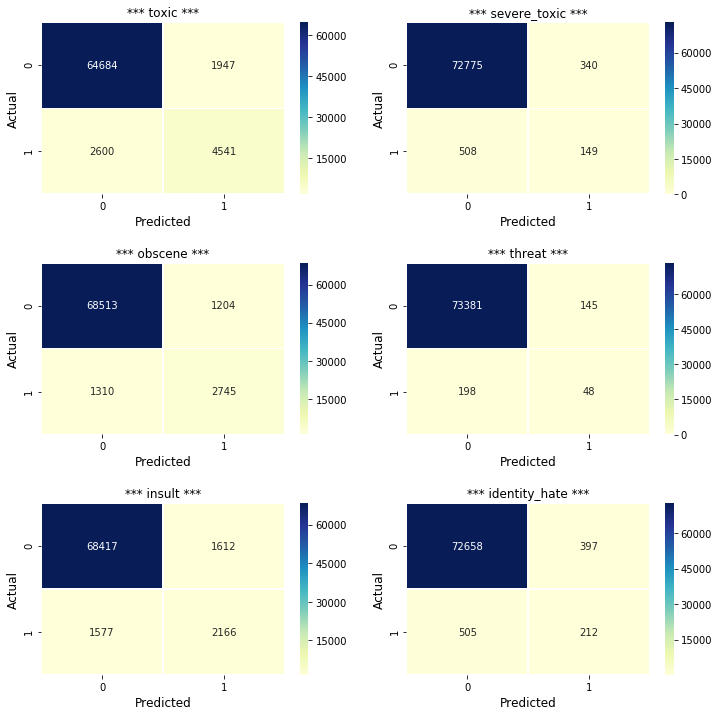

In [14]:
plt.rcParams['figure.figsize'] = [12, 12]
cf=1
for category in categories:
    plt.subplot(3,2,cf)
    plt.subplots_adjust(hspace=0.4)
    sns.heatmap(conf_mat[category],annot=True, fmt='d', linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.title(f'*** {category} ***')
    cf+=1

### LabelPowerset + LinearSVC w/ CountVectorizer

In [38]:
lbs_pipeline = Pipeline([
                    ('vect', CountVectorizer(min_df=10, ngram_range=(1, 1),stop_words='english')),
                    ('clf', LabelPowerset(LinearSVC()))])

lbs_pipeline.fit(X_train, train[categories].values)

prediction = lbs_pipeline.predict(X_test)   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [41]:
prediction = prediction.toarray()

In [42]:
print('For all (6) labels:')
print('\t accuracy = {:.2%}'.format(accuracy_score(test[categories].values, prediction)))
print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[categories].values, prediction)))

print('For individual labels:')

conf_mat = {}
count_n = 0

for category in categories:
    
    conf_mat[category] = confusion_matrix(test[category], prediction[:,count_n])
    tn,fp,fn,tp = conf_mat[category].ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)      
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('\t {}:'.format(category))
    print('\t accuracy= {:.2%}'.format(accuracy_score(test[category].values, prediction[:,count_n])))
    print('\t precision = {:.2%}'.format(precision))
    print('\t recall = {:.2%}'.format(recall))
    print('\t f1 score = {:.2%}'.format(f1))
    print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[category].values, prediction[:,count_n])))

    count_n +=1

For all (6) labels:
	 accuracy = 89.52%
	 hamming_loss = 2.95%

For individual labels:
	 toxic:
	 accuracy= 93.38%
	 precision = 71.19%
	 recall = 53.02%
	 f1 score = 60.78%
	 hamming_loss = 6.62%

	 severe_toxic:
	 accuracy= 98.52%
	 precision = 20.54%
	 recall = 22.98%
	 f1 score = 21.70%
	 hamming_loss = 1.48%

	 obscene:
	 accuracy= 96.28%
	 precision = 71.66%
	 recall = 53.51%
	 f1 score = 61.27%
	 hamming_loss = 3.72%

	 threat:
	 accuracy= 99.57%
	 precision = 25.00%
	 recall = 14.63%
	 f1 score = 18.46%
	 hamming_loss = 0.43%

	 insult:
	 accuracy= 95.91%
	 precision = 61.92%
	 recall = 50.57%
	 f1 score = 55.68%
	 hamming_loss = 4.09%

	 identity_hate:
	 accuracy= 98.66%
	 precision = 28.21%
	 recall = 24.83%
	 f1 score = 26.41%
	 hamming_loss = 1.34%



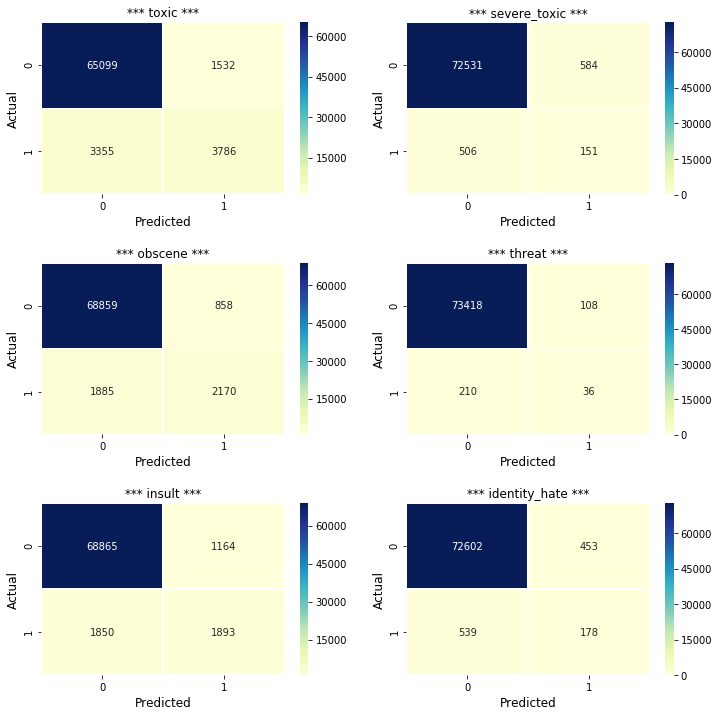

In [43]:
plt.rcParams['figure.figsize'] = [12, 12]
cf=1
for category in categories:
    plt.subplot(3,2,cf)
    plt.subplots_adjust(hspace=0.4)
    sns.heatmap(conf_mat[category],annot=True, fmt='d', linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.title(f'*** {category} ***')
    cf+=1

### MLkNN w/ TfidfVectorizer

In [55]:
# Tune parameter min_df

k_knn = [3,5,7,9,11]

for num in k_knn:
    mlknn_pipeline = Pipeline([
                    ('vect', TfidfVectorizer(min_df=1, ngram_range=(1, 2),stop_words='english')),
                    ('clf', MLkNN(k = num))])

    mlknn_pipeline.fit(X_train, train[categories].values)

    prediction = mlknn_pipeline.predict(X_train)
    
    prediction = prediction.toarray()
    
    print('k_knn = {}; accuracy = {:.2%}'.format(num, accuracy_score(train[categories].values, prediction)))

min_df = 3; accuracy = 99.28%
min_df = 5; accuracy = 89.71%
min_df = 7; accuracy = 89.63%
min_df = 9; accuracy = 89.63%
min_df = 11; accuracy = 90.01%


In [56]:
mlknn_pipeline = Pipeline([
                    ('vect', CountVectorizer(min_df=1, ngram_range=(1, 2),stop_words='english')),
                    ('clf', MLkNN(k=3))])

mlknn_pipeline.fit(X_train, train[categories].values)

prediction = mlknn_pipeline.predict(X_test)   

In [57]:
prediction = prediction.toarray()

In [58]:
print('For all (6) labels:')
print('\t accuracy = {:.2%}'.format(accuracy_score(test[categories].values, prediction)))
print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[categories].values, prediction)))

print('For individual labels:')

conf_mat = {}
count_n = 0

for category in categories:
    
    conf_mat[category] = confusion_matrix(test[category], prediction[:,count_n])
    tn,fp,fn,tp = conf_mat[category].ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)      
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('\t {}:'.format(category))
    print('\t accuracy= {:.2%}'.format(accuracy_score(test[category].values, prediction[:,count_n])))
    print('\t precision = {:.2%}'.format(precision))
    print('\t recall = {:.2%}'.format(recall))
    print('\t f1 score = {:.2%}'.format(f1))
    print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[category].values, prediction[:,count_n])))

    count_n +=1

For all (6) labels:
	 accuracy = 88.42%
	 hamming_loss = 3.12%

For individual labels:
	 toxic:
	 accuracy= 92.70%
	 precision = 75.52%
	 recall = 36.41%
	 f1 score = 49.13%
	 hamming_loss = 7.30%

	 severe_toxic:
	 accuracy= 99.07%
	 precision = 38.41%
	 recall = 8.07%
	 f1 score = 13.33%
	 hamming_loss = 0.93%

	 obscene:
	 accuracy= 95.04%
	 precision = 54.42%
	 recall = 60.07%
	 f1 score = 57.11%
	 hamming_loss = 4.96%

	 threat:
	 accuracy= 99.67%
	 precision = 50.94%
	 recall = 10.98%
	 f1 score = 18.06%
	 hamming_loss = 0.33%

	 insult:
	 accuracy= 95.73%
	 precision = 73.49%
	 recall = 24.66%
	 f1 score = 36.93%
	 hamming_loss = 4.27%

	 identity_hate:
	 accuracy= 99.05%
	 precision = 59.77%
	 recall = 7.25%
	 f1 score = 12.94%
	 hamming_loss = 0.95%



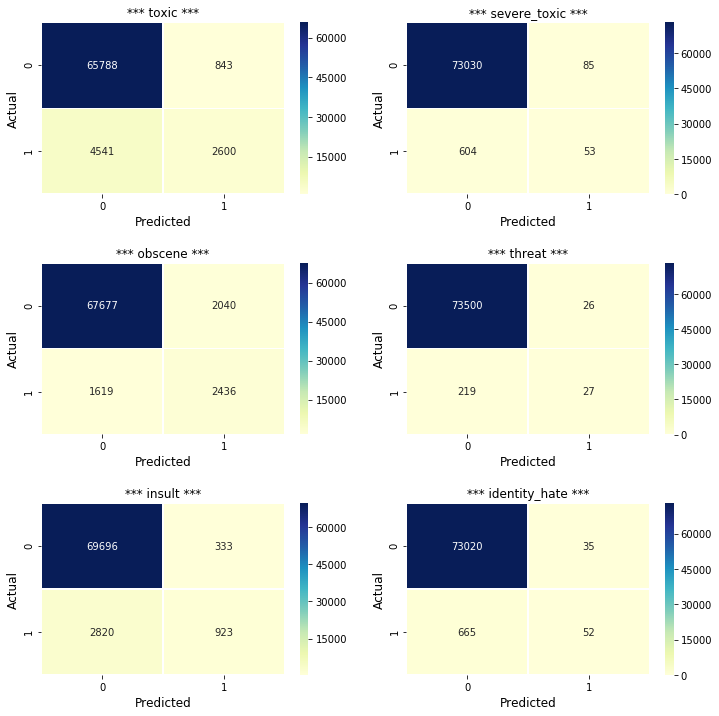

In [59]:
plt.rcParams['figure.figsize'] = [12, 12]
cf=1
for category in categories:
    plt.subplot(3,2,cf)
    plt.subplots_adjust(hspace=0.4)
    sns.heatmap(conf_mat[category],annot=True, fmt='d', linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.title(f'*** {category} ***')
    cf+=1